<a href="https://colab.research.google.com/github/enessoztrk/ImbalancedData_BankCredit_Classification/blob/master/Bank_Credit_Analysis_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Credit Analysis - Classification


## Business Problem

Danışmanlık müşterilerimizden bir banka, bankanın müşterilerinden kredi başvurusunda bulunanların kredi alıp almayacağı konusunda sonuç üretecek bir makine öğrenimi modeli talep etti.
*   Data Quality 
*   Descriptive Statistics
*   Modelling
*   Evaluation





### Libraries

In [877]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 1. Data Quality


Müşteriler hakkında bilgi içeren veri setidir ve bilgilerden faydalı içgörüler elde etmek ve yeni bir müşterinin bir kredi teklifini kabul edip etmeyeceğini tahmin etmek için çalışacağız.

1 - **age**: Müşterinin yaşı


2 - **job**: müşteri mesleğidir(kategorik)

*   admin
*   blue-collar
*   entrepreneur
*   housemaid
*   management
*   self-employed
*   retired
*   unemployed
*   unknown
*   services
*   student
*   technician

3 - **marital**: medeni durum(kategorik)

*   married
*   single
*   divorced

Not: '**divorced**', boşanmış veya dul anlamına gelir





4 - **education**: eğitim durumu(kategorik)



*   primary
*   secondary
*   tertiary
*   unknown



5 - **balance**: banka bakiyesi



6- **housing**: Konut kredisi var mı? (kategorik: 'no','yes','unknown')



7 - **campaign**: bu kampanya sırasında ve bu müşteri için gerçekleştirilen iletişim sayısı (sayısal)

8 - **duration**: saniye cinsinden temas süresi (sayısal)

9 - **approval**: müşteri kredi aldı mı? (binary: 'yes', 'no')





In [878]:
def load():
    df = pd.read_csv('/content/Credit.csv')
    return df

df = load()

In [879]:
# Overview

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(4521, 9)
##################### Types #####################
age          float64
job           object
marital       object
education     object
balance        int64
housing       object
duration     float64
campaign       int64
approval      object
dtype: object
##################### Head #####################
     age          job  marital  education  balance housing  duration  \
0 30.000   unemployed  married    primary     1787      no    79.000   
1 33.000     services  married  secondary     4789     yes   220.000   
2 35.000   management   single   tertiary     1350     yes   185.000   
3 30.000   management  married   tertiary     1476     yes   199.000   
4 59.000  blue-collar  married  secondary        0     yes   226.000   

   campaign approval  
0         1       no  
1         1       no  
2         1       no  
3         4       no  
4         1       no  
##################### NA #####################
age          2
job  

In [880]:
# Capture of Numerical and Category Variables 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

        Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
        Note: Categorical variables include categorical variables with numeric appearance.

        Parameters
        ------
            dataframe: dataframe
                    Dataframe to get variable names
            cat_th: int, optional
                    class threshold for numeric but categorical variables
            car_th: int, optinal
                    class threshold for categorical but cardinal variables

        Returns
        ------
            cat_cols: list
                    Categorical variable list
            num_cols: list
                    Numeric variable list
            cat_but_car: list
                    List of cardinal variables with categorical view

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = total number of variables
            num_but_cat is inside cat_cols.
            The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

        """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"observations: {dataframe.shape[0]}")
    print(f"variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 4521
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [881]:
cat_cols

['job', 'marital', 'education', 'housing', 'approval']

In [882]:
num_cols

['age', 'balance', 'duration', 'campaign']

In [883]:
df = df[(df['age'] >= 18) & (df['age'] < 70) | ((df['age'] >= 71) & (df['approval'] == 'yes'))]

df["age"].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.000    19.000
0.050    27.000
0.500    39.000
0.950    58.000
0.990    66.000
1.000   338.000
Name: age, dtype: float64

In [884]:
df = df[df["duration"] >= 0]
df["duration"].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.000          4.000
0.050         30.000
0.500        185.000
0.950        762.650
0.990       1277.310
1.000   23956498.000
Name: duration, dtype: float64

In [885]:
# Outlier Analysis

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [886]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [887]:
duration_index = grab_outliers(df, "duration", True)

        age            job   marital  education  balance housing     duration  \
125  34.000  self-employed    single   tertiary      462      no     1877.000   
568  59.000     unemployed   married    primary        0      no     3025.000   
852  36.000     management   married  secondary     -148      no  1440000.000   
880  26.000         admin.    single  secondary      255      no   457008.000   
980  43.000     management  divorced   tertiary      388     yes     2087.000   
2377 35.000     technician    single  secondary        2      no 23956498.000   
2827 49.000       services   married  secondary      320      no     1971.000   
2875 29.000     technician    single  secondary      778     yes     1994.000   
3673 36.000   entrepreneur   married   tertiary     3057      no     2769.000   
3853 54.000     technician   married  secondary     -315      no     2029.000   
4123 47.000    blue-collar  divorced    primary      126     yes     2456.000   

      campaign approval  
1

In [888]:
df = df.drop([852, 2377,568,2875])

In [889]:
balance_index = grab_outliers(df, "balance", True)

        age            job   marital  education  balance housing  duration  \
64   56.000         admin.   married  secondary    16873      no   223.000   
650  33.000      housemaid    single   tertiary    23663     yes   199.000   
871  31.000      housemaid    single    primary    26965      no   654.000   
877  30.000     management    single   tertiary    19358      no   258.000   
922  67.000    blue-collar   married  secondary    16353      no   223.000   
1031 49.000        retired    single    primary    25824      no    94.000   
1216 29.000     management    single   tertiary    15459      no   245.000   
1483 43.000     technician    single   tertiary    27733     yes   164.000   
1776 43.000     management   married  secondary    17555      no    14.000   
1778 56.000     management   married   tertiary    15520      no   420.000   
1821 51.000      housemaid   married    unknown    21244      no   166.000   
1881 36.000     management   married   tertiary    27359     yes

In [890]:
df = df[~df.index.isin([3553, 871])]

In [891]:
campaign_index = grab_outliers(df, "campaign", True)

        age            job   marital  education  balance housing  duration  \
298  38.000   entrepreneur   married  secondary      593     yes  1484.000   
454  44.000     management   married   tertiary      795      no    99.000   
514  36.000     management   married   tertiary     -381     yes    30.000   
553  42.000  self-employed   married   tertiary     1932     yes   192.000   
829  35.000     management    single   tertiary      714     yes   135.000   
943  40.000     technician   married  secondary      109      no   402.000   
1363 53.000  self-employed   married   tertiary     2627     yes    18.000   
1433 33.000    blue-collar    single  secondary    13494     yes    27.000   
1492 34.000     technician   married   tertiary     5060     yes    12.000   
2001 45.000    blue-collar   married    primary      137     yes   187.000   
2083 42.000         admin.   married  secondary      214     yes    21.000   
2218 58.000    blue-collar   married    primary        0     yes

In [892]:
df = df[~df.index.isin([298])]

In [893]:
# Outlier Check

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [894]:
for col in num_cols:
    print(col, check_outlier(df, col))

age True
balance True
duration True
campaign True


In [895]:
# Aykırı Değerlerin Baskılanması

# def replace_with_thresholds(dataframe, variable):
#     low_limit, up_limit = outlier_thresholds(dataframe, variable)
#     dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
#     dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [896]:
# Delete Outlier 

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

Eşik aralıkları belirlendi, yukarı ve aşağı değerlerin dışında kalan gözlemler drop edildi.

In [897]:
for col in num_cols:
     df = remove_outlier(df, col)
     
# Check
for col in num_cols:
      print(col, check_outlier(df, col))

age False
balance True
duration False
campaign True


In [898]:
df["duration"].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.000      4.000
0.050     32.000
0.500    185.000
0.950    755.550
0.990   1210.220
1.000   1816.000
Name: duration, dtype: float64

In [899]:
# Missing Value Analysis

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

na_cols = missing_values_table(df, True)

           n_miss  ratio
job             6  0.140
education       4  0.090
marital         3  0.070
housing         3  0.070


In [900]:
missing_values = df[df.isnull().any(axis=1)]
print(missing_values)

        age            job   marital  education  balance housing  duration  \
18   25.000    blue-collar    single    primary     -221     NaN   250.000   
59   54.000     technician  divorced  secondary      784     NaN   579.000   
91   34.000    blue-collar   married    primary      455     NaN   372.000   
456  34.000  self-employed       NaN   tertiary     5462      no   430.000   
2179 51.000            NaN   married   tertiary       -3      no    91.000   
2194 47.000            NaN   married   tertiary      -50      no   175.000   
2243 32.000            NaN   married  secondary      401     yes   294.000   
2347 35.000            NaN    single   tertiary       71     yes   836.000   
2481 30.000            NaN   married   tertiary      931      no  1183.000   
2646 40.000            NaN   married   tertiary     1734     yes   169.000   
2863 31.000     management       NaN   tertiary      385     yes   304.000   
2954 51.000       services       NaN  secondary        0      no

In [901]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

missing_vs_target(df, "campaign", na_cols)

# tüm sayısal sütunlar için gözlemlenebilir('age', 'balance', 'duration', 'campaign')

             TARGET_MEAN  Count
job_NA_FLAG                    
0                  2.640   4384
1                  4.333      6


                 TARGET_MEAN  Count
marital_NA_FLAG                    
0                      2.643   4387
1                      1.667      3


                   TARGET_MEAN  Count
education_NA_FLAG                    
0                        2.641   4386
1                        4.000      4


                 TARGET_MEAN  Count
housing_NA_FLAG                    
0                      2.643   4387
1                      1.667      3




In [902]:
df = df[(df['approval'] == 'yes') | (df['approval'].isna()) | (df.dropna(subset=['approval'])['approval'] == 'no')]

# 2. Descriptive Statistics

               job  Ratio
blue-collar    933 21.253
management     931 21.207
technician     754 17.175
admin.         470 10.706
services       410  9.339
retired        195  4.442
self-employed  178  4.055
entrepreneur   160  3.645
unemployed     124  2.825
housemaid      108  2.460
student         84  1.913
unknown         37  0.843


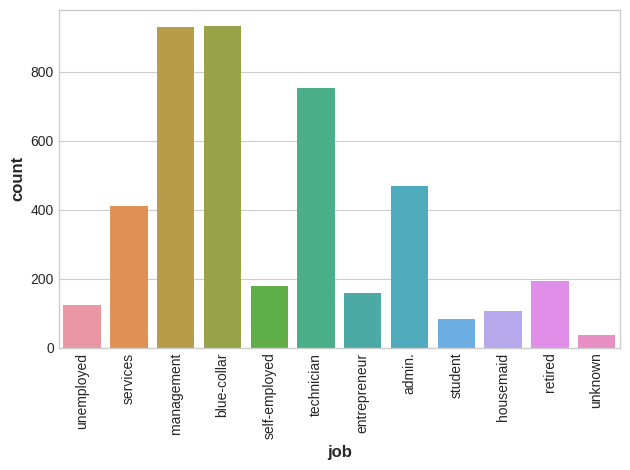

          marital  Ratio
married      2707 61.663
single       1167 26.583
divorced      513 11.686


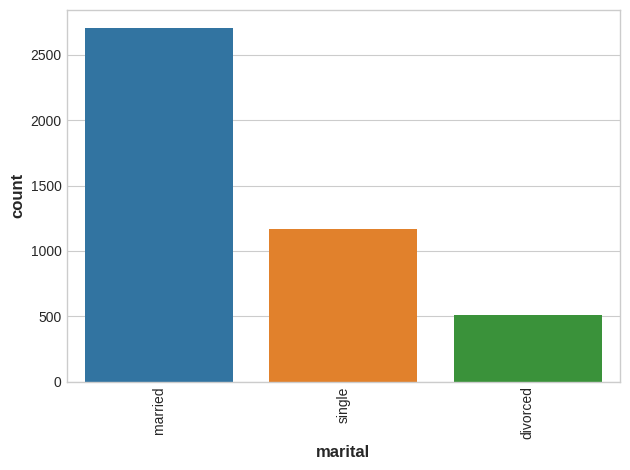

           education  Ratio
secondary       2254 51.344
tertiary        1299 29.590
primary          652 14.852
unknown          181  4.123


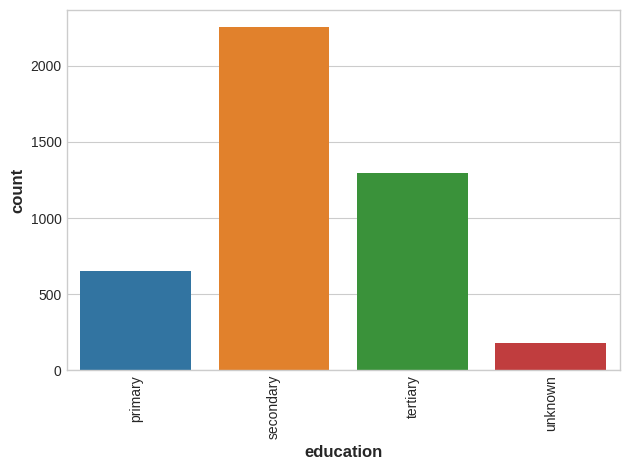

     housing  Ratio
yes     2503 57.016
no      1884 42.916


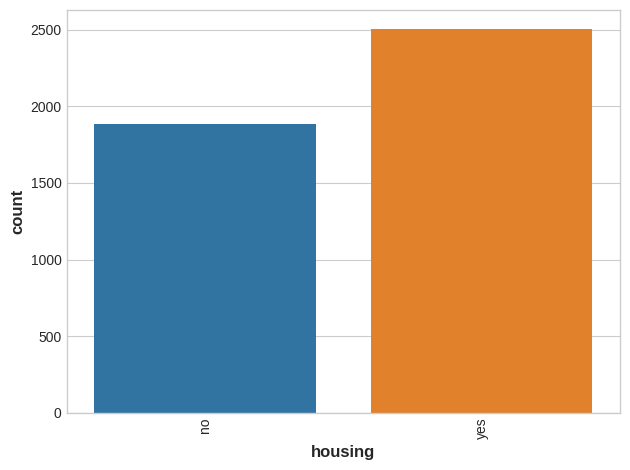

     approval  Ratio
no       3883 88.451
yes       507 11.549


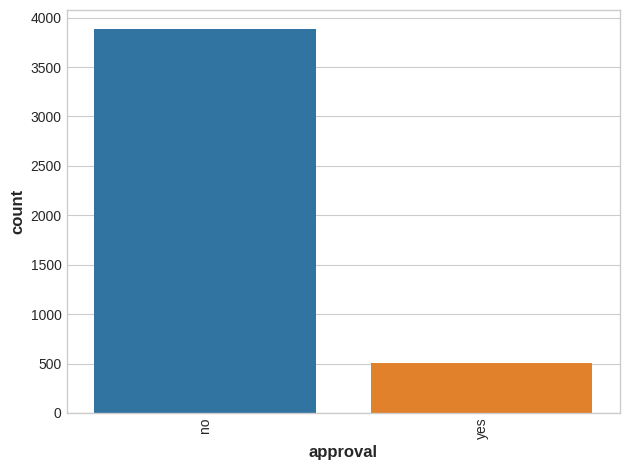

In [903]:
# Analysis of Categorical Variables

def cat_summary(dataframe, col_name, plot=False):
     print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                         "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
     if plot:
         sns.countplot(x=dataframe[col_name], data=dataframe)
         plt.xticks(rotation=90)
         plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

# Yaşın neden max 99 seçildiğini retired oranından anlaşılabilir.

count   4390.000
mean      40.867
std       10.139
min       19.000
5%        27.000
10%       29.000
20%       32.000
30%       34.000
40%       36.000
50%       39.000
60%       42.000
70%       46.000
90%       56.000
95%       58.000
99%       65.110
max       87.000
Name: age, dtype: float64


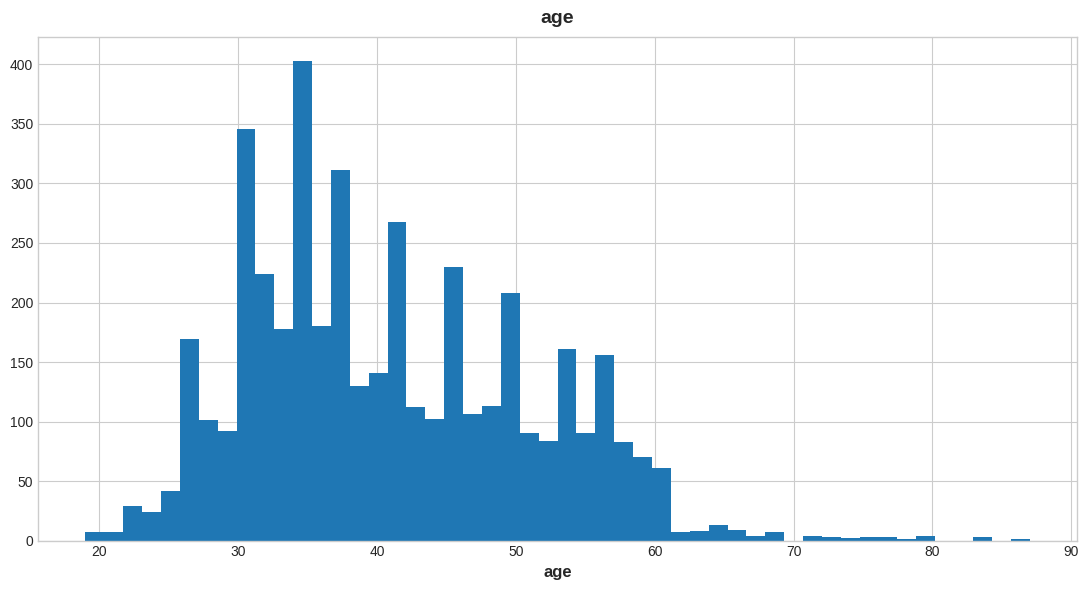

count    4390.000
mean     1232.739
std      2109.728
min     -2082.000
5%       -162.000
10%         0.000
20%        22.000
30%       124.000
40%       259.000
50%       435.500
60%       702.400
70%      1114.000
90%      3658.500
95%      5481.800
99%     10786.110
max     15030.000
Name: balance, dtype: float64


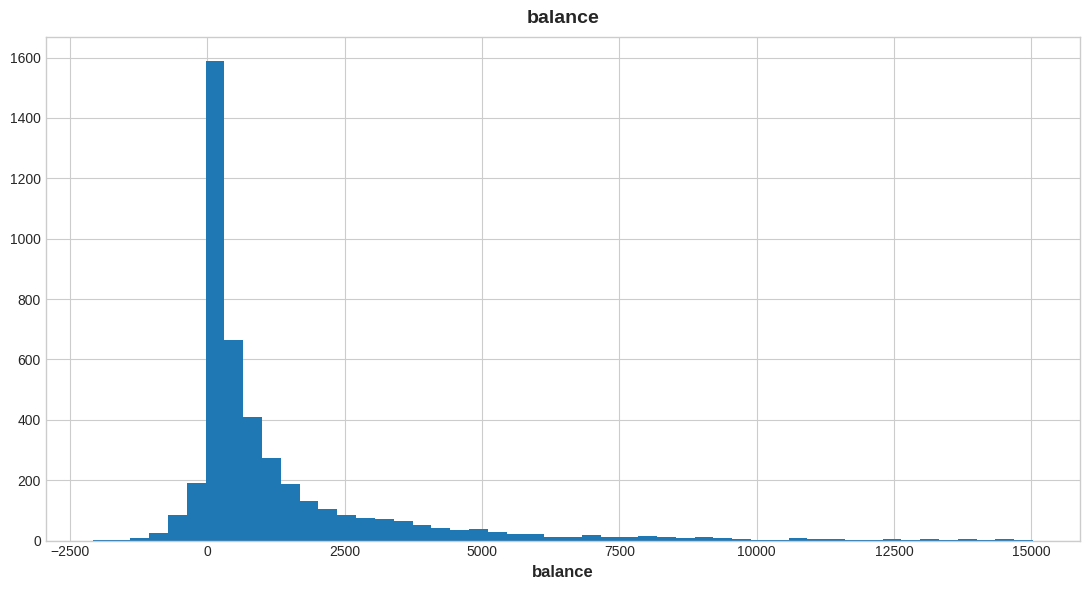

count   4390.000
mean     260.582
std      244.695
min        4.000
5%        32.000
10%       58.000
20%       89.000
30%      119.000
40%      148.000
50%      185.000
60%      227.000
70%      284.000
90%      574.000
95%      755.550
99%     1210.220
max     1816.000
Name: duration, dtype: float64


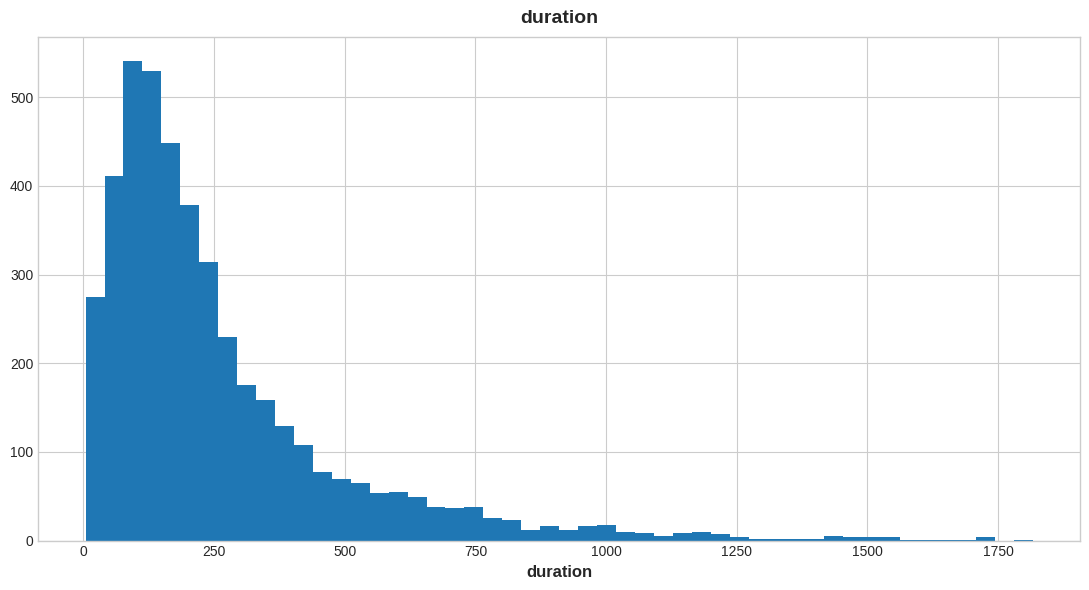

count   4390.000
mean       2.642
std        2.436
min        1.000
5%         1.000
10%        1.000
20%        1.000
30%        1.000
40%        2.000
50%        2.000
60%        2.000
70%        3.000
90%        5.000
95%        7.000
99%       13.000
max       18.000
Name: campaign, dtype: float64


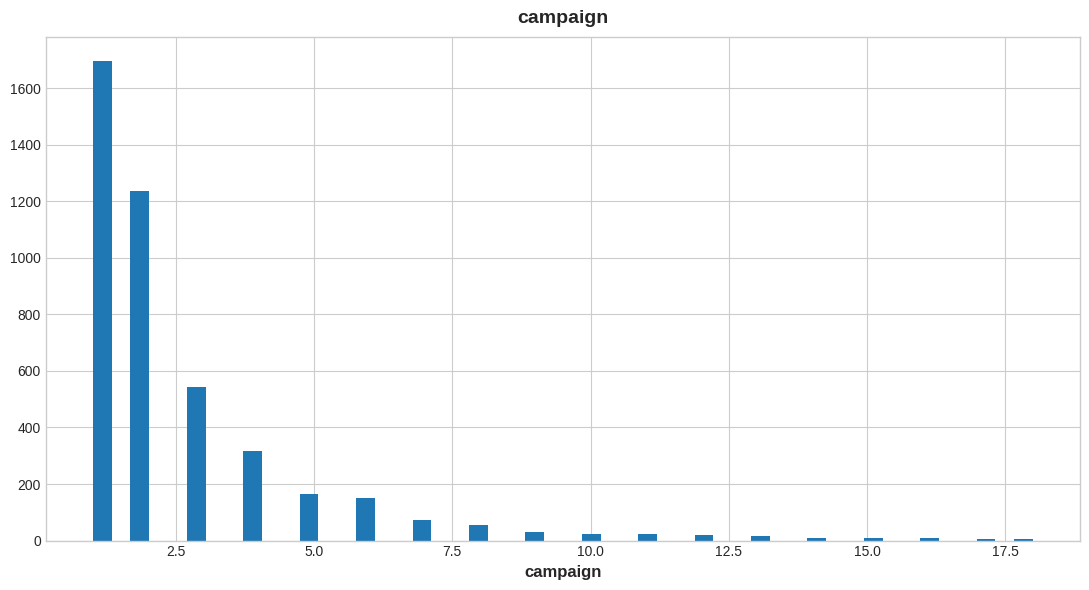

In [904]:
# Analysis of Numerical Variables

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50, figsize=(11,6))
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

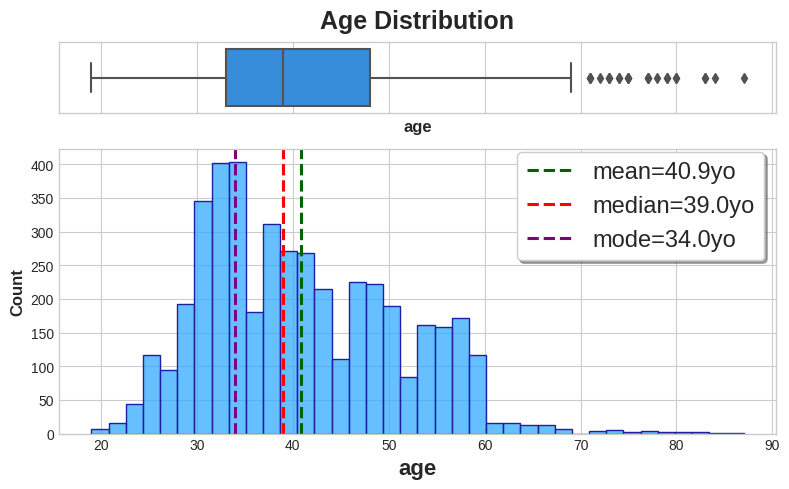

In [905]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0],color = "#1D8EF5")
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1],color = "#33AAFF", edgecolor="#1D1EA2")
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linestyle='--',linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linestyle='--',linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linestyle='--',linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

num_plot(df, 'age', 'Age Distribution', 'yo')

The distribution of 'age' is right skewed.


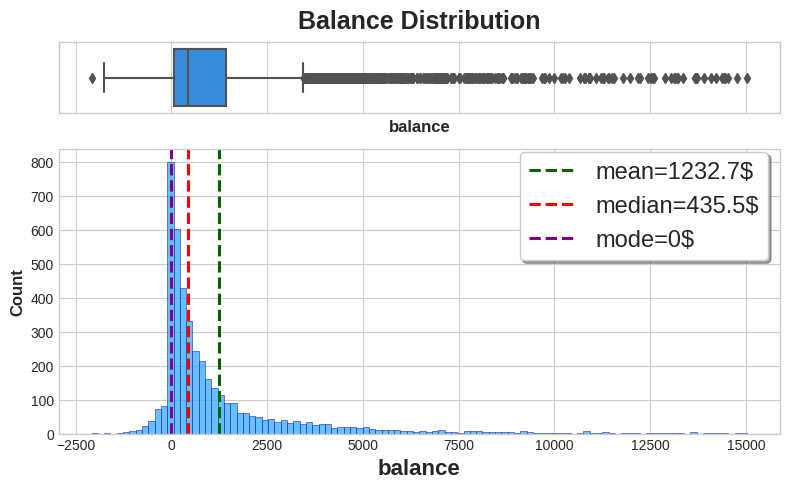

In [906]:
num_plot(df, 'balance', 'Balance Distribution', '$')

The distribution is heavily skewed to the right, with some negative values.
 
I assumed that the balance column was negative and the person was indebted and better actions should be taken by communicating with the necessary departments.

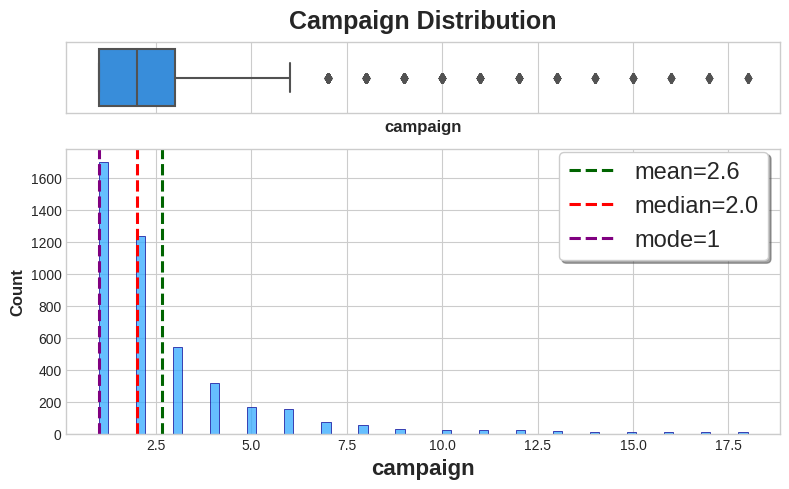

In [907]:
num_plot(df, 'campaign', 'Campaign Distribution', '')

This variable presents a long tail distribtion, as the previous ones.

In [908]:
# Rare Analysis

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "balance", cat_cols)

# ['age', 'balance', 'duration', 'campaign']

job : 12
               COUNT  RATIO  TARGET_MEAN
admin.           470  0.107     1108.466
blue-collar      933  0.213     1022.227
entrepreneur     160  0.036     1051.881
housemaid        108  0.025     1490.880
management       931  0.212     1486.104
retired          195  0.044     1653.595
self-employed    178  0.041     1329.624
services         410  0.093     1003.373
student           84  0.019     1543.821
technician       754  0.172     1226.887
unemployed       124  0.028     1121.532
unknown           37  0.008     1532.757


marital : 3
          COUNT  RATIO  TARGET_MEAN
divorced    513  0.117     1062.546
married    2707  0.617     1243.048
single     1167  0.266     1281.799


education : 4
           COUNT  RATIO  TARGET_MEAN
primary      652  0.149     1196.897
secondary   2254  0.513     1088.997
tertiary    1299  0.296     1466.254
unknown      181  0.041     1494.878


housing : 2
     COUNT  RATIO  TARGET_MEAN
no    1884  0.429     1351.272
yes   2503  0.570     1

As can be seen, there are few data from some professions. Applicants from these professions may seem low because our data is imbalanced.

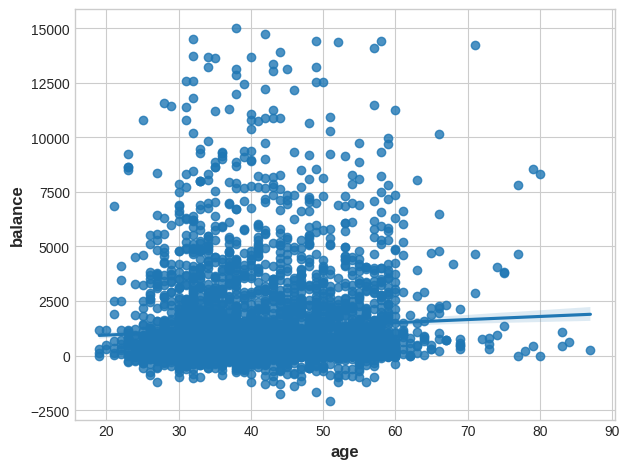

In [909]:
sns.regplot(x='age',y='balance', data=df)
plt.show()

This plot looks messy, we will create a categorical column for 'age'.



In [910]:
df["age_cut"] = pd.cut(df['age'], bins=[0, 35, 55, 70, float('Inf')], labels=['0-35', '35-55', '55-70', '70-100'])

**More data should be added to our dataset, but overall reviews have been done.**

**In order for all these graphs to give correct results, there should be no imbalance data.** 


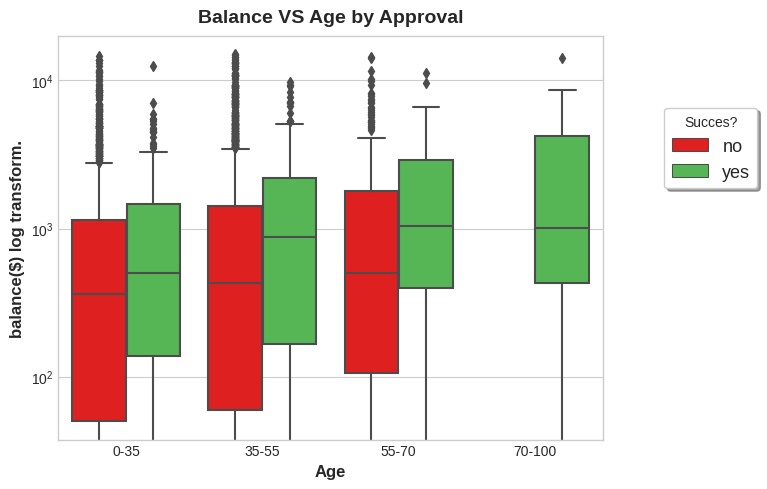

In [911]:
palette = {'yes':'green', 'no':'red'}
palette = {'yes':'#46C646', 'no':'#FF0000'}

plt.figure(figsize=(8,5))
sns.boxplot(x='age_cut', y='balance', hue='approval', data=df, palette=palette)
plt.ylabel('balance($) log transform.')
plt.xlabel('Age')
plt.title('Balance VS Age by Approval')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.3, 0.6), title='Succes?', loc = 'lower right', fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

From this plot we can see that older customers tends to have a higher bank balance and that customers who accepted the deposit tended to have a higher balance compared to the customers who refused the deposit. 

In [912]:
df = df.drop('age_cut', axis=1)

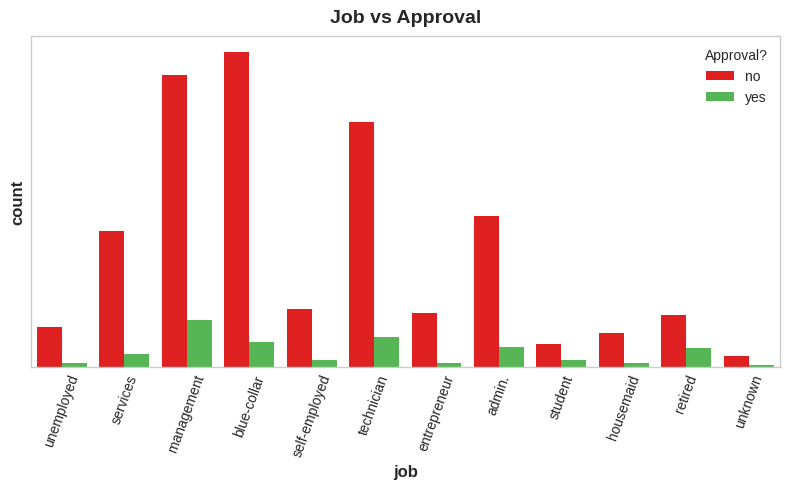

In [913]:
# Job Vs Approval

plt.figure(figsize=(8, 5));
plt.title('Job vs Approval')
g = sns.countplot(x= 'job', hue = 'approval', data=df, palette=palette)
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.show()

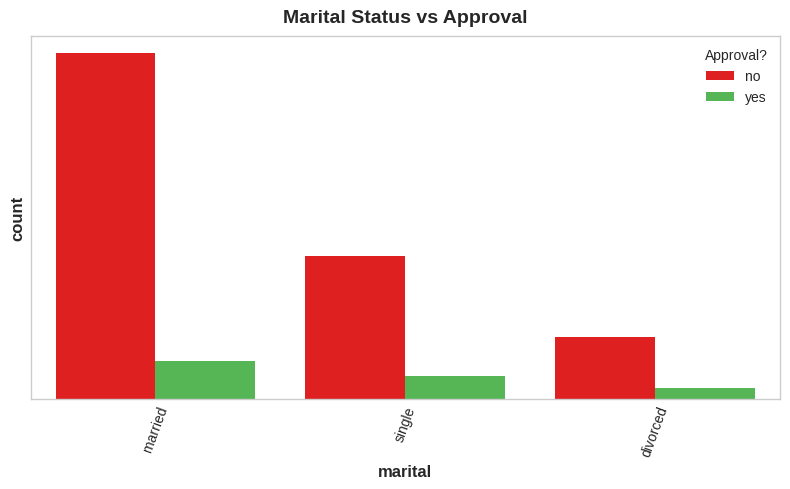

In [914]:
# Marital Status vs Campaign Success

plt.figure(figsize=(8, 5));
plt.title('Marital Status vs Approval')
g = sns.countplot(x= 'marital', hue = 'approval', data=df, palette=palette);
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.show()

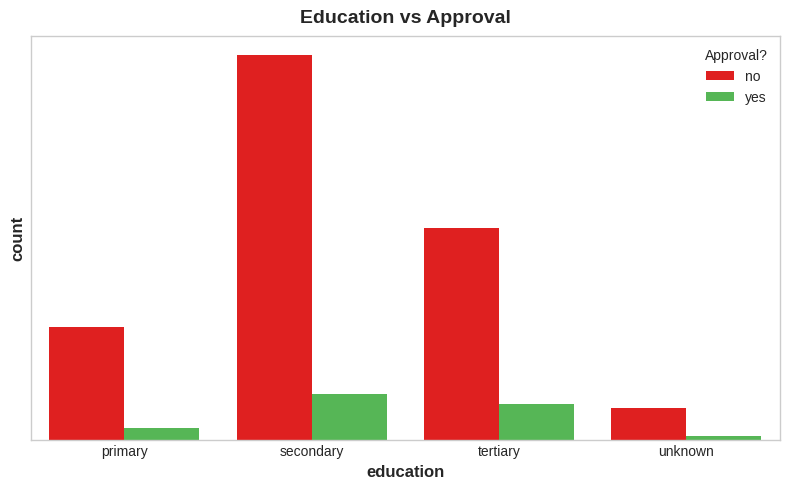

In [915]:
plt.figure(figsize=(8, 5));
plt.title('Education vs Approval')
g = sns.countplot(x= 'education', hue = 'approval', data=df, palette=palette);
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
plt.show()

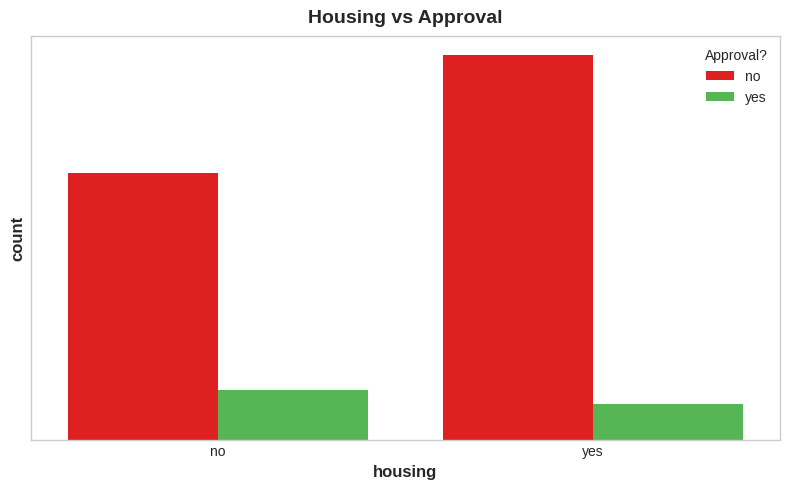

In [916]:
plt.figure(figsize=(8, 5));
plt.title('Housing vs Approval')
g = sns.countplot(x= 'housing', hue = 'approval', data=df, palette=palette);
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
plt.show()

In [917]:
# Analysis of Correlation

corr = df[num_cols].corr()
corr

,age,balance,duration,campaign
age,1.000,0.068,-0.011,0.005
balance,0.068,1.000,0.002,-0.014
duration,-0.011,0.002,1.000,-0.069
campaign,0.005,-0.014,-0.069,1.000


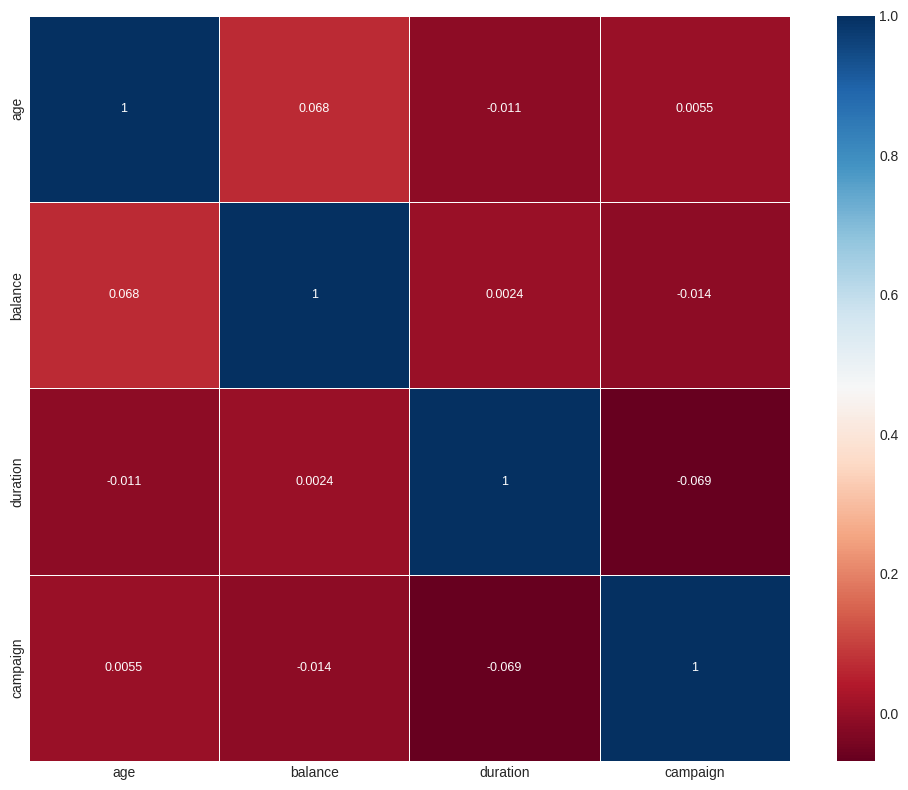

In [918]:
def correlation_matrix(df, cols):
     fig = plt.gcf()
     fig.set_size_inches(10, 8)
     plt.xticks(fontsize=10)
     plt.yticks(fontsize=10)
     fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 9}, linecolor='w', cmap='RdBu')
     plt.show(block=True)

correlation_matrix(df, num_cols)

###Summary
Tanımlayıcı verilerimizin çoğu "sayısal" sütunlarda değil, "kategorik sütunlarda" bulunduğundan, tanımlayıcı veri setinden elde edebileceğimiz çok fazla içgörü yoktur.

**İş Sayısı**: Mavi yaka, bu veri setinde daha yaygın olan meslektir.(Yönetim ile hemen hemen aynı)

**Mesleğe Göre Yaş**: Beklendiği gibi, medyan yaş ortalaması en yüksek olanlar emekliler, en düşük olanlar ise öğrencilerdir.

**Mesleğe Göre Bakiye**: Yönetim ve Emekliler, hesaplarında en yüksek bakiyeye sahip olanlardır.

**Bakiyeye Göre Medeni Durum**: Bakiye gözlemleri, boşandıktan sonra finansal varlıkları bölmek zorunda kaldıkları için daha düşük çıktı.

**Konut Bakiyesi**: Potansiyel müşterinin daha önce konut kredisi kullanıp kullanmadığı, sahip olduğu bakiye miktarı üzerinde önemli bir etkiye sahiptir.

**Verilerimiz dengesiz olduğu için tüm bu yorumlar yalnızca analiz amaçlıdır.**

# Modelling

In [919]:
# Capture of Numerical and Category Variables 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

        Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
        Note: Categorical variables include categorical variables with numeric appearance.

        Parameters
        ------
            dataframe: dataframe
                    Dataframe to get variable names
            cat_th: int, optional
                    class threshold for numeric but categorical variables
            car_th: int, optinal
                    class threshold for categorical but cardinal variables

        Returns
        ------
            cat_cols: list
                    Categorical variable list
            num_cols: list
                    Numeric variable list
            cat_but_car: list
                    List of cardinal variables with categorical view

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = total number of variables
            num_but_cat is inside cat_cols.
            The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

        """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"observations: {dataframe.shape[0]}")
    print(f"variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 4390
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [920]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

observations: 4390
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [921]:
# Mesleklerin gelir aralıklarını belirle
income_ranges = {
    "management": "yüksek gelirli",
    "blue-collar": "orta gelirli",
    "technician": "orta gelirli",
    "admin.": "orta gelirli",
    "services": "düşük gelirli",
    "self-employed": "yüksek gelirli",
    "retired": "düşük gelirli",
    "entrepreneur": "yüksek gelirli",
    "unemployed": "düşük gelirli",
    "housemaid": "düşük gelirli",
    "student": "düşük gelirli",
    "unknown": "düşük gelirli"
}
df["income_range"] = df["job"].map(income_ranges)

# Yaşa göre grupla
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], labels=['18-25', '25-40', '40-50', '50-60', '60+'])

# Bakiyeye göre grupla
df['balance_group'] = pd.cut(df['balance'], bins=[-3000, 0, 100, 1000, 10000, np.inf], labels=['borçlu', '0-100', '100-1k', '1k-10k', '10k+'])

# Aramaların sayısına göre grupla
df["campaign_group"] = pd.cut(df["campaign"], bins=[0, 2, 4, 6, 8, 16], labels=['1-2', '2-3', '3-4', '4-5', '5+'], include_lowest=True)

# Arama süresine göre grupla
df['duration_group'] = pd.cut(df['duration'], bins=[0, 30, 60, 300, np.inf], labels=['kısa', 'orta', 'uzun', 'çok uzun'])

cat_cols = ['job', 'marital', 'education', 'housing', 'approval', 'income_range', 'campaign_group', 'duration_group', 'age_group', 'balance_group']

In [922]:
df["campaign"].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

0.000    1.000
0.050    1.000
0.500    2.000
0.950    7.000
0.990   13.000
1.000   18.000
Name: campaign, dtype: float64

In [923]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [924]:
# MinMaxScaler is used because negative values are also available.
scaler = MinMaxScaler()
df["balance"] = scaler.fit_transform(df[['balance']])

standart_scaler = StandardScaler()
df["age"] = standart_scaler.fit_transform(df[['age']])

scaler = MinMaxScaler()
df["duration"] = standart_scaler.fit_transform(df[['duration']])

df.dropna(inplace=True)

In [925]:
df["duration"].describe().T

count   4390.000
mean      -0.000
std        1.000
min       -1.049
25%       -0.640
50%       -0.309
75%        0.276
max        6.357
Name: duration, dtype: float64

In [926]:
# Split data into features and target 

X = df.drop('approval_yes', axis=1)
y = df['approval_yes']

To monitor accuracy in the validation set and avoid overfitting, we split the trainset into a new train and validation set.

In [927]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [928]:
# Apply the SMOTE algorithm to balance the data
# n_job: Uses the entire processor of the running environment. 

smote = SMOTE(n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# {'early_stopping_rounds': 5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.1}

In [929]:
# !pip install lazypredict

In [930]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(predictions = True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:04<00:00,  6.04it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.788,0.749,0.749,0.817,0.018
BernoulliNB,0.829,0.653,0.653,0.837,0.020
LinearDiscriminantAnalysis,0.884,0.638,0.638,0.870,0.043
SGDClassifier,0.852,0.619,0.619,0.846,0.097
DecisionTreeClassifier,0.849,0.618,0.618,0.844,0.037
LGBMClassifier,0.887,0.607,0.607,0.865,0.126
AdaBoostClassifier,0.886,0.603,0.603,0.863,0.184
XGBClassifier,0.874,0.596,0.596,0.854,0.413
Perceptron,0.851,0.589,0.589,0.839,0.021


In [931]:
from sklearn.neighbors import NearestCentroid
model = NearestCentroid()

In [932]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append(cs[i])
                    break

    return dups

duplicated_cols = duplicate_columns(X_resampled)
X_resampled = X_resampled.loc[:,~X_resampled.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [933]:
# Train the model on the training set
model.fit(X_resampled, y_resampled)

NearestCentroid()

Specificity: 0.8208955223880597


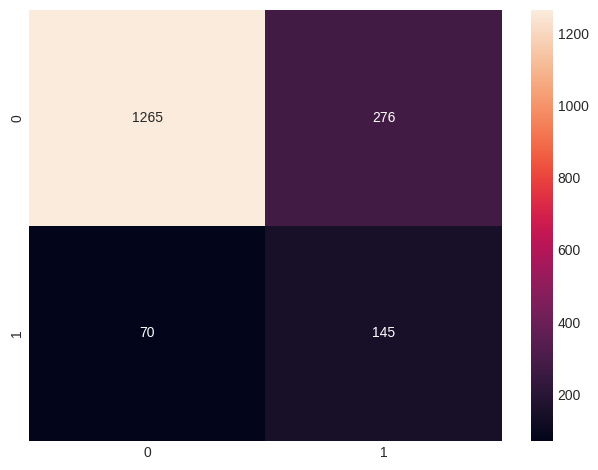

In [934]:
# Evaluate the model on the test set

y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True, fmt='g');

print("Specificity:",specificity)

In [935]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1541
           1       0.34      0.67      0.46       215

    accuracy                           0.80      1756
   macro avg       0.65      0.75      0.67      1756
weighted avg       0.87      0.80      0.83      1756

